In [31]:
import pandas as pd
import numpy as np
import geopandas as gpd
import glob
import matplotlib.pyplot as plt
import seaborn as sns

In [174]:
# EC = pd.read_csv('./../../../../../../../Downloads/Postcode_level_all_meters_electricity_2021.csv')
EC2 = pd.read_csv('./../../../../../../../Downloads/LSOA_domestic_elec_2010-21.csv')
GC2 = pd.read_csv('./../../../../../../../Downloads/LSOA_domestic_gas_2010-21.csv')
# UPRN.to_csv('./../../../../../../../Desktop/MAV/UPRN_postcode_LSOA_lookup.csv')
UPRN = pd.read_csv('./../../../../../../../Desktop/MAV/UPRN_postcode_LSOA_lookup.csv')
LSOA = gpd.read_file('./../../Data/boundaries/LSOA_2021.geojson')

list_paths = glob.glob('./../../../../../../../Downloads/ONSUD_JAN_2023_GB/Data/*')

UPRN = pd.DataFrame(data = {'UPRN':[],'PCDS':[],'lsoa21cd':[]})

for i in list_paths:
    file = pd.read_csv(i)
    file = file.loc[:,['UPRN','PCDS','lsoa21cd']]
    UPRN = pd.concat([UPRN,file])

In [196]:
def load_clean_epc(path_to_epc, path_save_cleaned, columns_keep, UPRN_data):
    #list_paths = glob.glob("../Data/Energy_Performance_Certificate/all-domestic-certificates/*")
    import glob
    import pandas as pd

    list_paths = glob.glob(path_to_epc)
    
    for i in range(len(list_paths)):
        path = list_paths[i] + '/certificates.csv'
        name = list_paths[i][-20:]
        epc = pd.read_csv(path, usecols=columns_keep) # columns = ['TOTAL_FLOOR_AREA','UPRN','LODGEMENT_DATE']
        # clean the uprn and add
        epc['UPRN'] = epc['UPRN'].astype('float64')
        epc2 = epc.merge(UPRN_data, on = 'UPRN',how = 'left')
        # clean duplicates
        epc2['LODGEMENT_DATE'] = pd.to_datetime(epc2['LODGEMENT_DATE'], format='%Y-%m-%d')
        epc2 = epc2.sort_values(by="LODGEMENT_DATE").drop_duplicates(subset=["UPRN"], keep="last")
        epc2 = epc2.loc[epc2.groupby('UPRN').LODGEMENT_DATE.idxmax()]
        # save to new folder
        epc2.to_csv(str(path_save_cleaned +  name + '.csv')) # path_save_cleaned = './../Data/Energy_Performance_Certificate/cerificates_processed/'
    
    return('done')

In [197]:
load_clean_epc(path_to_epc = './../../../../../../../Desktop/MAV/all-domestic-certificates/*', 
               path_save_cleaned = './../../../../../../../Desktop/MAV/jamie_certificates/', 
               columns_keep = ['UPRN','POSTCODE','CURRENT_ENERGY_EFFICIENCY',
                               'POTENTIAL_ENERGY_EFFICIENCY','LODGEMENT_DATE',
                               'ENERGY_CONSUMPTION_CURRENT','ENERGY_CONSUMPTION_POTENTIAL','TOTAL_FLOOR_AREA'], 
               UPRN_data = UPRN)

'done'

In [198]:
def load_all_cleaned_certificates(folder_path):
    list_of_paths = glob.glob(folder_path)
    data = pd.DataFrame()
    for i in range(len(list_of_paths)):
        x = pd.read_csv(list_of_paths[i])
        data = pd.concat([data,x])
    return(data)

all_epc = load_all_cleaned_certificates('./../../../../../../../Desktop/MAV/jamie_certificates/*')

In [199]:
all_epc.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17661317 entries, 0 to 42389
Data columns (total 12 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   Unnamed: 0.1                  int64  
 1   POSTCODE                      object 
 2   CURRENT_ENERGY_EFFICIENCY     int64  
 3   POTENTIAL_ENERGY_EFFICIENCY   int64  
 4   LODGEMENT_DATE                object 
 5   ENERGY_CONSUMPTION_CURRENT    int64  
 6   ENERGY_CONSUMPTION_POTENTIAL  float64
 7   TOTAL_FLOOR_AREA              float64
 8   UPRN                          float64
 9   Unnamed: 0                    float64
 10  PCDS                          object 
 11  lsoa21cd                      object 
dtypes: float64(4), int64(4), object(4)
memory usage: 1.7+ GB


In [207]:
all_epc['TOTAL_FLOOR_AREA'].unique()

array([  98.   ,   99.   ,   90.   , ...,   10.52 ,  244.923, 1438.8  ])

In [204]:
all_epc['ENERGY_CONSUMPTION_CURRENT_kWh_per_meter'] = all_epc['ENERGY_CONSUMPTION_CURRENT'] * all_epc['TOTAL_FLOOR_AREA']
all_epc['ENERGY_CONSUMPTION_POTENTIAL_kWh_per_meter'] = all_epc['ENERGY_CONSUMPTION_POTENTIAL'] * all_epc['TOTAL_FLOOR_AREA']

In [208]:
all_epc.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17661317 entries, 0 to 42389
Data columns (total 14 columns):
 #   Column                                      Dtype  
---  ------                                      -----  
 0   Unnamed: 0.1                                int64  
 1   POSTCODE                                    object 
 2   CURRENT_ENERGY_EFFICIENCY                   int64  
 3   POTENTIAL_ENERGY_EFFICIENCY                 int64  
 4   LODGEMENT_DATE                              object 
 5   ENERGY_CONSUMPTION_CURRENT                  int64  
 6   ENERGY_CONSUMPTION_POTENTIAL                float64
 7   TOTAL_FLOOR_AREA                            float64
 8   UPRN                                        float64
 9   Unnamed: 0                                  float64
 10  PCDS                                        object 
 11  lsoa21cd                                    object 
 12  ENERGY_CONSUMPTION_CURRENT_kWh_per_meter    float64
 13  ENERGY_CONSUMPTION_POTENTIAL_kWh_

In [118]:
# PC_level = all_epc.iloc[:,[1,2,3,5,6]].groupby('POSTCODE').mean().reset_index()
# PC_level = PC_level.merge(EC, left_on = 'POSTCODE', right_on = 'Postcode', how = 'outer')

In [215]:
mean = all_epc.iloc[:,[2,3,5,6,7,12,13,11]].groupby('lsoa21cd'
                                           ).mean(
                                           ).reset_index(
                                           ).rename(columns = {'CURRENT_ENERGY_EFFICIENCY':'EPC: MEAN_CURRENT_ENERGY_EFFICIENCY', 
                                                                'POTENTIAL_ENERGY_EFFICIENCY':'EPC: MEAN_POTENTIAL_ENERGY_EFFICIENCY',
                                                                'ENERGY_CONSUMPTION_CURRENT':'EPC: MEAN_ENERGY_CONSUMPTION_CURRENT',
                                                                'ENERGY_CONSUMPTION_POTENTIAL':'EPC: MEAN_ENERGY_CONSUMPTION_POTENTIAL',
                                                                'ENERGY_CONSUMPTION_CURRENT_kWh_per_meter':'EPC: MEAN_ENERGY_CONSUMPTION_CURRENT_kWh_per_meter',
                                                                'ENERGY_CONSUMPTION_POTENTIAL_kWh_per_meter':'EPC: MEAN_ENERGY_CONSUMPTION_POTENTIAL_kWh_per_meter'})
median = all_epc.iloc[:,[2,3,5,6,12,13,11]].groupby('lsoa21cd'
                                             ).median(
                                             ).reset_index(
                                             ).rename(columns = {'CURRENT_ENERGY_EFFICIENCY':'EPC: MEDIAN_CURRENT_ENERGY_EFFICIENCY', 
                                                                    'POTENTIAL_ENERGY_EFFICIENCY':'EPC: MEDIAN_POTENTIAL_ENERGY_EFFICIENCY',
                                                                    'ENERGY_CONSUMPTION_CURRENT':'EPC: MEDIAN_ENERGY_CONSUMPTION_CURRENT',
                                                                    'ENERGY_CONSUMPTION_POTENTIAL':'EPC: MEDIAN_ENERGY_CONSUMPTION_POTENTIAL',
                                                                'ENERGY_CONSUMPTION_CURRENT_kWh_per_meter':'EPC: MEDIAN_ENERGY_CONSUMPTION_CURRENT_kWh_per_meter',
                                                                'ENERGY_CONSUMPTION_POTENTIAL_kWh_per_meter':'EPC: MEDIAN_ENERGY_CONSUMPTION_POTENTIAL_kWh_per_meter'})

EPC_part = mean.merge(median, on = 'lsoa21cd')

In [223]:
EPC_part.columns

Index(['lsoa21cd', 'EPC: MEAN_CURRENT_ENERGY_EFFICIENCY',
       'EPC: MEAN_POTENTIAL_ENERGY_EFFICIENCY',
       'EPC: MEAN_ENERGY_CONSUMPTION_CURRENT',
       'EPC: MEAN_ENERGY_CONSUMPTION_POTENTIAL', 'TOTAL_FLOOR_AREA',
       'EPC: MEAN_ENERGY_CONSUMPTION_CURRENT_kWh_per_meter',
       'EPC: MEAN_ENERGY_CONSUMPTION_POTENTIAL_kWh_per_meter',
       'EPC: MEDIAN_CURRENT_ENERGY_EFFICIENCY',
       'EPC: MEDIAN_POTENTIAL_ENERGY_EFFICIENCY',
       'EPC: MEDIAN_ENERGY_CONSUMPTION_CURRENT',
       'EPC: MEDIAN_ENERGY_CONSUMPTION_POTENTIAL',
       'EPC: MEDIAN_ENERGY_CONSUMPTION_CURRENT_kWh_per_meter',
       'EPC: MEDIAN_ENERGY_CONSUMPTION_POTENTIAL_kWh_per_meter'],
      dtype='object')

In [217]:
LSOA_comb = LSOA.iloc[:,[1,2,4]].merge(
    EPC_part.merge(
    EC2.iloc[:,[0,2,3,4,5]].merge(
        GC2.iloc[:,[0,2,3,4,5,6]], on = 'lsoa21cd', how = 'outer'
            ), on = 'lsoa21cd', how = 'outer'
            ), left_on ='LSOA21CD', right_on = 'lsoa21cd')

In [221]:
LSOA_comb.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 35672 entries, 0 to 35671
Data columns (total 26 columns):
 #   Column                                                  Non-Null Count  Dtype   
---  ------                                                  --------------  -----   
 0   LSOA21CD                                                35672 non-null  object  
 1   LSOA21NM                                                35672 non-null  object  
 2   geometry                                                35672 non-null  geometry
 3   lsoa21cd                                                35672 non-null  object  
 4   EPC: MEAN_CURRENT_ENERGY_EFFICIENCY                     35672 non-null  float64 
 5   EPC: MEAN_POTENTIAL_ENERGY_EFFICIENCY                   35672 non-null  float64 
 6   EPC: MEAN_ENERGY_CONSUMPTION_CURRENT                    35672 non-null  float64 
 7   EPC: MEAN_ENERGY_CONSUMPTION_POTENTIAL                  35672 non-null  float64 
 8   TOTAL_FLOOR_AREA  

In [222]:
LSOA_comb.to_file('./../../Data/Jamie_project/EPC_METER_consumption_data_LSOA.geojson')
pd.DataFrame(LSOA_comb.drop(columns={'geometry'}, axis=1)).to_csv('./../../../../../../../Documents/GIT/energy_consumption_proj/EPC_METER_consumption_data_LSOA.csv')

/opt/anaconda3/envs/env04/lib/python3.11/site-packages/geopandas/plotting.py:651: FutureWarning: 'axes' is deprecated, please use 'ax' instead (for consistency with pandas)
  warnings.warn(


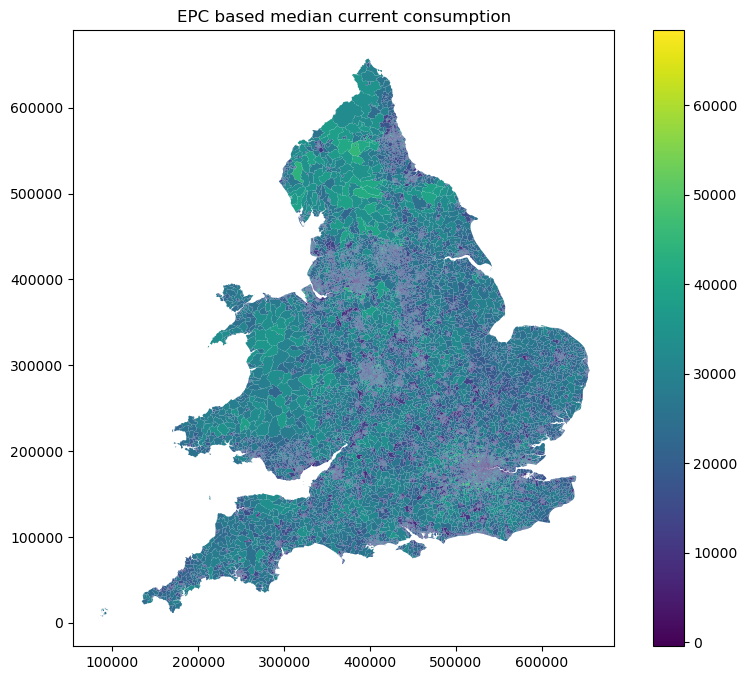

In [228]:
f, ax = plt.subplots(1, figsize=(10, 8))
LSOA_comb.plot('EPC: MEDIAN_ENERGY_CONSUMPTION_CURRENT_kWh_per_meter', legend = True, axes = ax)
plt.title('EPC based median current consumption')
plt.show()

/opt/anaconda3/envs/env04/lib/python3.11/site-packages/geopandas/plotting.py:651: FutureWarning: 'axes' is deprecated, please use 'ax' instead (for consistency with pandas)
  warnings.warn(


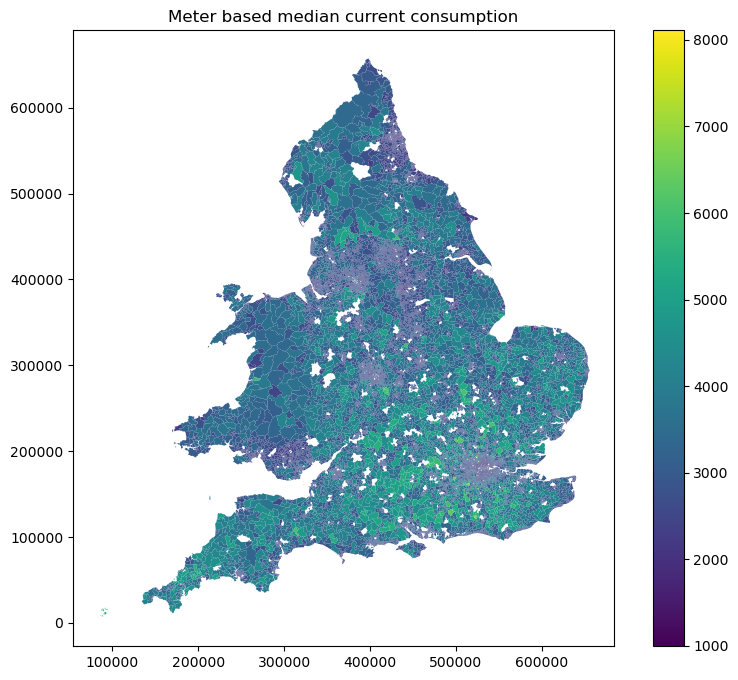

In [229]:
f, ax = plt.subplots(1, figsize=(10, 8))
LSOA_comb.plot('ELEC: Median consumption (kWh per meter)', legend = True, axes = ax)
plt.title('Meter based median current consumption')
plt.show()

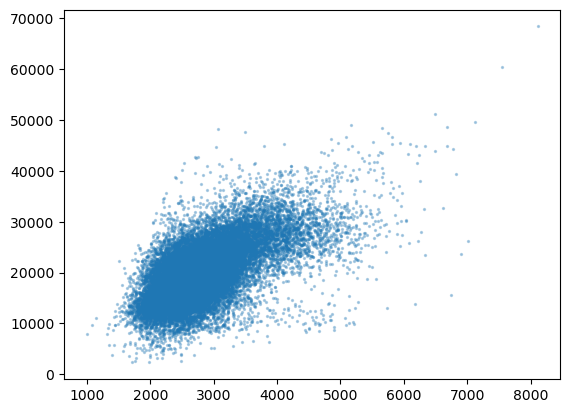

In [231]:
plt.scatter(LSOA_comb['ELEC: Median consumption (kWh per meter)'], LSOA_comb['EPC: MEDIAN_ENERGY_CONSUMPTION_CURRENT_kWh_per_meter'], s = 2, alpha = 0.3);

/opt/anaconda3/envs/env04/lib/python3.11/site-packages/geopandas/plotting.py:651: FutureWarning: 'axes' is deprecated, please use 'ax' instead (for consistency with pandas)
  warnings.warn(


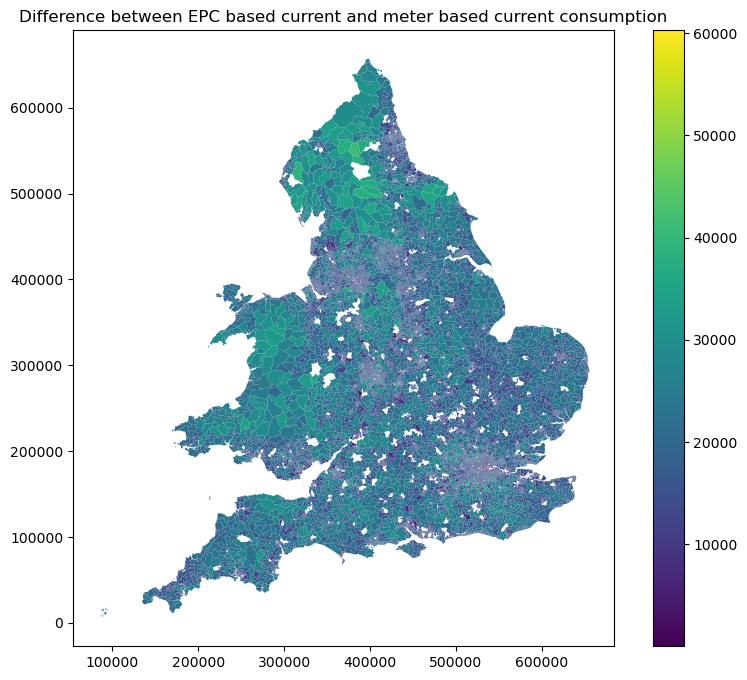

In [234]:
f, ax = plt.subplots(1, figsize=(10, 8))
LSOA_comb.plot(LSOA_comb['EPC: MEDIAN_ENERGY_CONSUMPTION_CURRENT_kWh_per_meter'] - LSOA_comb['ELEC: Median consumption (kWh per meter)'], legend = True, axes = ax)
plt.title('Difference between EPC based current and meter based current consumption')
plt.show()

/opt/anaconda3/envs/env04/lib/python3.11/site-packages/geopandas/plotting.py:651: FutureWarning: 'axes' is deprecated, please use 'ax' instead (for consistency with pandas)
  warnings.warn(


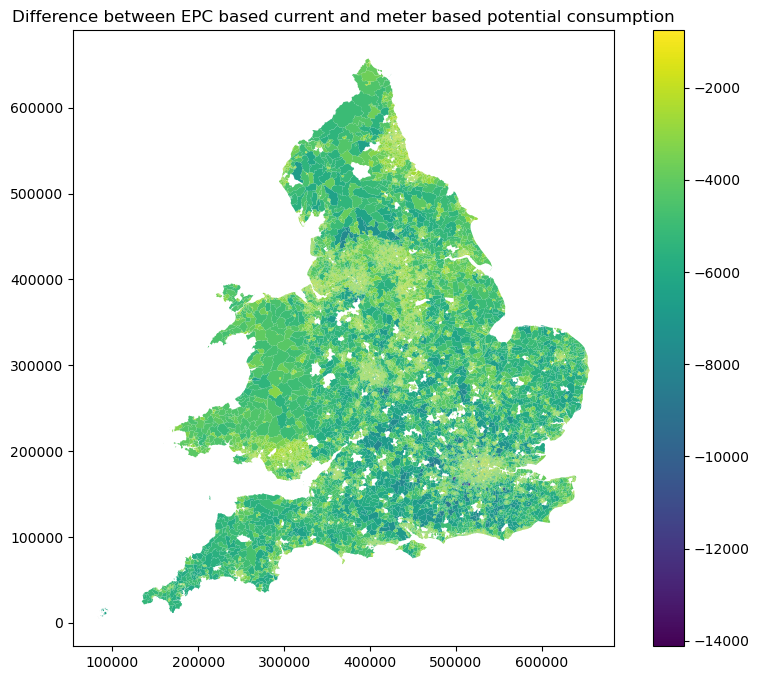

In [138]:
f, ax = plt.subplots(1, figsize=(10, 8))
LSOA.plot('diff_meter_current_EPC_potential', legend = True, axes = ax)
plt.title('Difference between EPC based current and meter based potential consumption')
plt.show()

In [2]:
LSOA_comb = gpd.read_file('./../../Data/Jamie_project/EPC_METER_consumption_data_LSOA.geojson')

In [10]:
IMD = gpd.read_file('./../../../../../../../Desktop/English_IMD_2019/IMD_2019.shp')
lookup = pd.read_csv('./../../../../../../../Desktop/English_IMD_2019/LSOA_(2011)_to_LSOA_(2021)_to_Local_Authority_District_(2022)_Lookup_for_England_and_Wales_(Version_2).csv')

In [11]:
IMD = pd.DataFrame(IMD.loc[:,['lsoa11cd','IMDDec0','IMDRank0','IMDScore']])
IMD

,lsoa11cd,IMDDec0,IMDRank0,IMDScore
0,E01000001,9,29199,6.208
1,E01000002,10,30379,5.143
2,E01000003,5,14915,19.402
3,E01000005,3,8678,28.652
4,E01000006,5,14486,19.837
...,...,...,...,...
32839,E01033764,1,116,74.468
32840,E01033765,1,945,59.599
32841,E01033766,4,12842,21.895
32842,E01033767,1,422,66.704


In [13]:
IMD = lookup.loc[:,['LSOA11CD','LSOA21CD']].merge(IMD, left_on = 'LSOA11CD', right_on = 'lsoa11cd')

In [16]:
LSOA_comb

,LSOA21CD,LSOA21NM,lsoa21cd,EPC: MEAN_CURRENT_ENERGY_EFFICIENCY,EPC: MEAN_POTENTIAL_ENERGY_EFFICIENCY,EPC: MEAN_ENERGY_CONSUMPTION_CURRENT,EPC: MEAN_ENERGY_CONSUMPTION_POTENTIAL,TOTAL_FLOOR_AREA,EPC: MEAN_ENERGY_CONSUMPTION_CURRENT_kWh_per_meter,EPC: MEAN_ENERGY_CONSUMPTION_POTENTIAL_kWh_per_meter,...,ELEC: Number of meters\n,ELEC: Total consumption (kWh),ELEC: Mean consumption (kWh per meter),ELEC: Median consumption (kWh per meter),GAS: Number of meters\n,GAS: Total consumption (kWh),GAS: Mean consumption (kWh per meter),GAS: Median consumption (kWh per meter),GAS: Number of non-consuming meters,geometry
0,E01000001,City of London 001A,E01000001,61.899396,66.931590,318.054326,286.056338,69.029195,21495.080848,19502.592118,...,1056.0,4226873.0,4003.0,3293.0,52.0,514999.0,9904.0,4248.0,NaN,"POLYGON ((532105.312 182010.574, 532162.491 18..."
1,E01000002,City of London 001B,E01000002,68.980119,72.093439,239.415507,214.624254,72.116799,18427.333579,16330.910378,...,1159.0,4206380.0,3629.0,2875.0,18.0,419923.0,23329.0,18852.0,NaN,"POLYGON ((532634.497 181926.016, 532619.141 18..."
2,E01000003,City of London 001C,E01000003,68.538660,73.469072,257.404639,214.074742,55.742330,12917.205848,10889.854763,...,1187.0,2972415.0,2504.0,1814.0,547.0,4168506.0,7621.0,6573.0,15.0,"POLYGON ((532135.138 182198.131, 532158.250 18..."
3,E01000005,City of London 001E,E01000005,71.205882,76.848039,224.426471,180.340686,53.356471,11573.905343,9186.974853,...,582.0,1692328.0,2908.0,1940.0,406.0,2879232.0,7092.0,4503.0,33.0,"POLYGON ((533808.018 180767.774, 533649.037 18..."
4,E01000006,Barking and Dagenham 016A,E01000006,62.807018,79.546366,272.526316,161.573935,83.921734,21554.688326,11531.549416,...,529.0,2124230.0,4016.0,3203.0,405.0,6383270.0,15761.0,14880.0,NaN,"POLYGON ((545122.049 184314.931, 545271.849 18..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35667,W01002036,Vale of Glamorgan 005G,W01002036,78.063772,83.938942,135.614654,100.154681,83.323669,10786.784814,7661.704630,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((317734.974 172707.277, 317873.187 17..."
35668,W01002037,Vale of Glamorgan 005H,W01002037,68.819565,81.243478,223.241304,127.871739,81.118630,17413.946130,9831.663478,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((319033.579 172604.209, 319009.058 17..."
35669,W01002038,Vale of Glamorgan 014G,W01002038,65.864796,79.867347,238.068878,131.408163,91.918357,21090.153388,11568.196255,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((306385.000 168776.000, 306363.000 16..."
35670,W01002039,Vale of Glamorgan 014H,W01002039,78.512367,89.491166,123.342756,46.443463,105.390138,13373.602180,5538.901297,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((306820.271 166519.139, 306844.281 16..."


In [18]:
LSOA_comb = LSOA_comb.merge(IMD.loc[:,['LSOA21CD','IMDDec0','IMDRank0','IMDScore']], on = 'LSOA21CD')
LSOA_comb.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 32844 entries, 0 to 32843
Data columns (total 29 columns):
 #   Column                                                  Non-Null Count  Dtype   
---  ------                                                  --------------  -----   
 0   LSOA21CD                                                32844 non-null  object  
 1   LSOA21NM                                                32844 non-null  object  
 2   lsoa21cd                                                32844 non-null  object  
 3   EPC: MEAN_CURRENT_ENERGY_EFFICIENCY                     32844 non-null  float64 
 4   EPC: MEAN_POTENTIAL_ENERGY_EFFICIENCY                   32844 non-null  float64 
 5   EPC: MEAN_ENERGY_CONSUMPTION_CURRENT                    32844 non-null  float64 
 6   EPC: MEAN_ENERGY_CONSUMPTION_POTENTIAL                  32844 non-null  float64 
 7   TOTAL_FLOOR_AREA                                        32844 non-null  float64 
 8   EPC: MEAN_ENERGY_C

In [1]:
LSOA_comb.to_file('./../../Data/Jamie_project/EPC_METER_consumption_data_LSOA.geojson')
LSOA_comb.to_file('./../../../../../../../Documents/GIT/energy_consumption_proj/EPC_METER_consumption_data_LSOA.geojson')
pd.DataFrame(LSOA_comb.drop(columns={'geometry'}, axis=1)).to_csv('./../../../../../../../Documents/GIT/energy_consumption_proj/EPC_METER_consumption_data_LSOA.csv')

NameError: name 'LSOA_comb' is not defined

In [21]:
sel = LSOA_comb.loc[:,['LSOA21CD','IMDDec0','IMDRank0','IMDScore', 'EPC: MEDIAN_ENERGY_CONSUMPTION_CURRENT_kWh_per_meter','ELEC: Median consumption (kWh per meter)', 'GAS: Median consumption (kWh per meter)']]
sel['combined_meter_consumption'] = sel['GAS: Median consumption (kWh per meter)'] + sel['ELEC: Median consumption (kWh per meter)']
sel

,LSOA21CD,IMDDec0,IMDRank0,IMDScore,EPC: MEDIAN_ENERGY_CONSUMPTION_CURRENT_kWh_per_meter,ELEC: Median consumption (kWh per meter),GAS: Median consumption (kWh per meter),combined_meter_consumption
0,E01000001,9,29199,6.208,18527.0,3293.0,4248.0,7541.0
1,E01000002,10,30379,5.143,14060.0,2875.0,18852.0,21727.0
2,E01000003,5,14915,19.402,11447.5,1814.0,6573.0,8387.0
3,E01000005,3,8678,28.652,10408.0,1940.0,4503.0,6443.0
4,E01000006,5,14486,19.837,20440.0,3203.0,14880.0,18083.0
...,...,...,...,...,...,...,...,...
32839,E01035754,10,31664,3.812,18228.0,NaN,NaN,NaN
32840,E01035755,10,29989,5.531,13762.0,NaN,NaN,NaN
32841,E01035757,9,27307,7.802,13682.0,NaN,NaN,NaN
32842,E01035759,9,29382,6.061,16901.5,NaN,NaN,NaN


In [24]:
def scale(x):
    y = (x-x.min())/(x.max()-x.min())
    return(y)


In [26]:
sel['EPC: MEDIAN_ENERGY_CONSUMPTION_CURRENT_kWh_per_meter'] = scale(sel['EPC: MEDIAN_ENERGY_CONSUMPTION_CURRENT_kWh_per_meter'])
sel['combined_meter_consumption'] = scale(sel['combined_meter_consumption'])

In [30]:
sel['ELEC: Median consumption (kWh per meter)'] = scale(sel['ELEC: Median consumption (kWh per meter)'])
sel['GAS: Median consumption (kWh per meter)'] = scale(sel['GAS: Median consumption (kWh per meter)'])

In [43]:
sel2 = sel[sel['IMDDec0'].isin([1,5,10])]

AttributeError: 'FacetGrid' object has no attribute 'set_title'

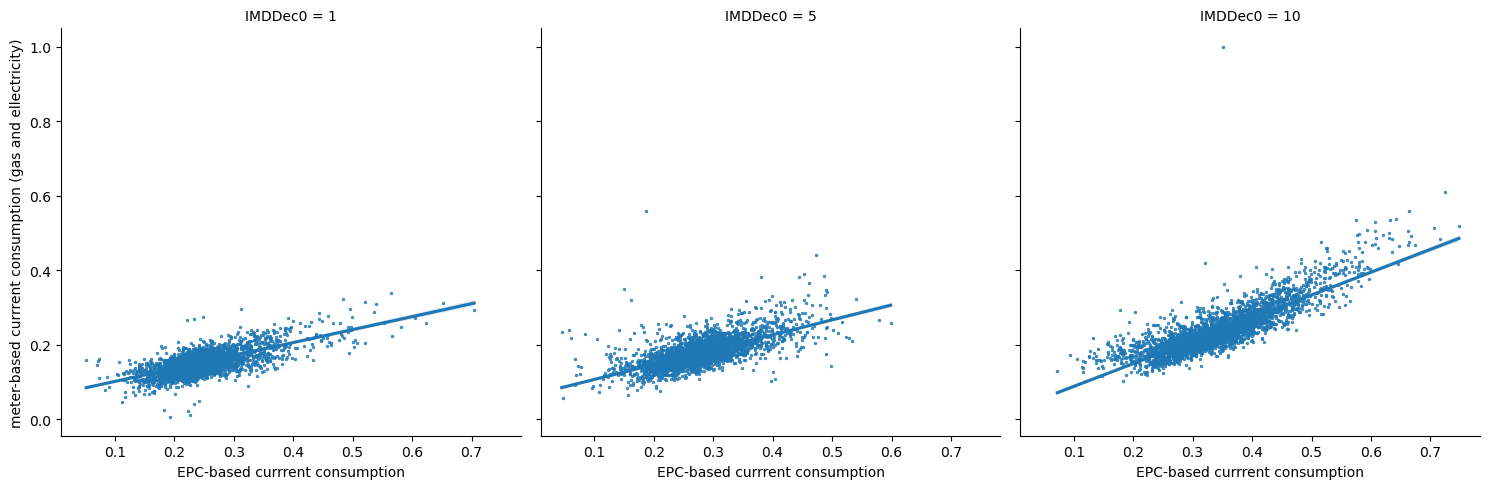

In [47]:
ax = sns.lmplot(x = 'EPC: MEDIAN_ENERGY_CONSUMPTION_CURRENT_kWh_per_meter' ,
           y = 'combined_meter_consumption',
           col = 'IMDDec0', 
           data = sel2, 
           robust= True,
           scatter_kws=dict(s=3, linewidths=.7))
ax.axes[0,0].set_xlabel("EPC-based currrent consumption")
ax.axes[0,0].set_ylabel("meter-based currrent consumption (gas and ellectricity)")
ax.axes[0,1].set_xlabel("EPC-based currrent consumption")
ax.axes[0,2].set_xlabel("EPC-based currrent consumption")
ax.set_title('EPC consumption vs Meter-based consumption by IMD');

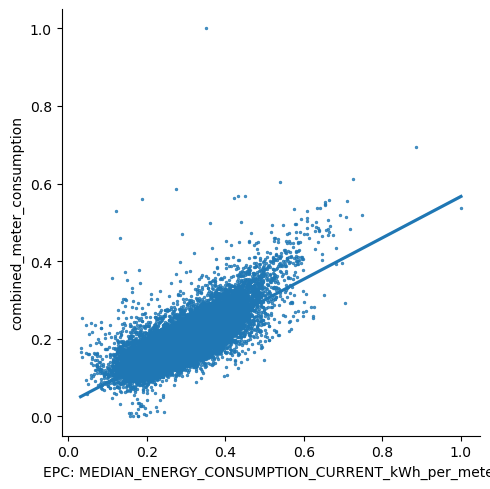

In [50]:
ax = sns.lmplot(x = 'EPC: MEDIAN_ENERGY_CONSUMPTION_CURRENT_kWh_per_meter' ,
           y = 'combined_meter_consumption',
           data = sel, 
           robust= True,
           scatter_kws=dict(s=3, linewidths=.7))
ax.set_xlabel("EPC-based currrent consumption")
ax.set_ylabel("meter-based currrent consumption (gas and ellectricity)")